In [1]:
import matplotlib.pyplot as plt
import numpy as np

#torch,torchvision, torchvision transforms
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F #useful library for operations like relu 
import torch.optim as optim

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize (inverse operation of normalization transform)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) #transforms to be used for datasets 

In [4]:
# acquiring the fashionmnist datasets
dataset = torchvision.datasets.FashionMNIST('',
    download=True,
    train=True,
    transform=transform) #if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
testset = torchvision.datasets.FashionMNIST('',
    download=True,
    train=False,
    transform=transform)#if not downloaded, downloads the fashionmnist data to a /data directory in the same folder
## Don't touch the test data 


split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 
length_valid=len(dataset)-length_train #number of validation samples 

trainset, valset = torch.utils.data.random_split(dataset, [length_train, length_valid])

In [6]:
print(trainset)

In [5]:
# dataloaders
#shuffle enabled as True for the train dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                        shuffle=True)

#shuffle enabled as False for the valid dataloader
valloader = torch.utils.data.DataLoader(valset, batch_size=100,
                                        shuffle=False) 

#shuffle enabled as False for the test dataloader
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        shuffle=False) 

In [6]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot') #classes for fashion mnist

In [31]:
#inspecting the length of datasets (test and train datasets)
num_train_samples=len(trainset)
print(num_train_samples)
num_test_samples=len(testset)
print(num_test_samples)
num_val_samples=len(valset)
print(num_val_samples)

48000
10000
12000


In [9]:
inputs,labels=next(iter(trainloader)) #generate a single batch from trainloader 
print(len(trainloader)) #number of batches 
48000//100 #no of samples // batch_size

480


480

In [10]:
print(inputs.size())

torch.Size([100, 1, 28, 28])


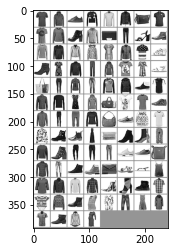

In [11]:
# create grid of images
img_grid = torchvision.utils.make_grid(inputs)

# show images
matplotlib_imshow(img_grid, one_channel=True)

In [12]:
#Declaring the network architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  #declare all layers
        self.linear_1=nn.Linear(784,100) #input_dimensions x output_dimensions
        self.dropout=nn.Dropout(p=0.3)
        self.linear_2=nn.Linear(100,10)
    def forward(self,x):
        #x is a single batch (batch_size,28,28,1)
        x=x.squeeze(1)# removing the 1 in input batch (resizing from (batch_size,1,28,28) to (batch_size,28,28))
        x=x.view(-1,28*28) #resizing from (batch_size,28*28) to (batch_size,784)
        x=self.linear_1(x) #passing through linear layer (784*128)
        x=F.relu(x) #passing through relu activation
        x=self.dropout(x)
        x=self.linear_2(x) #passing through output linear layer 
        return(x)

In [13]:
net=Net()

In [14]:
net

Net(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear_2): Linear(in_features=100, out_features=10, bias=True)
)

In [15]:
device = torch.device('cpu')
print(device)
net=net.to(device)

cpu


In [16]:
#defining the test/validation loop here 
#eval_model function runs the test/validation on the given data 
def eval_model(model,loader,criterion,device):
    """model: instance of model class 
       loader: test dataloader
       criterion: loss function
       device: CPU/GPU
    """
    model.eval() #needed to run the model in eval mode to freeze all the layers
    correct=0
    total=0
    total_loss=0
    with torch.no_grad():
        total=0
        correct=0
        for idx,(inputs,labels) in enumerate(loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            outputs=model(inputs)
            outputs=F.softmax(outputs,dim=1)
            val_loss=criterion(outputs,labels)
            total_loss=total_loss+val_loss
            preds=torch.max(outputs,dim=1)[1]
            
            correct=correct+(preds==labels).cpu().sum().numpy() 
            total=total+len(labels)
    Accuracy=100*(correct/total)
    fin_loss=total_loss/(len(loader))
    
    return(Accuracy,fin_loss)


In [17]:
#defining loss and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
num_epochs=5
net=net.to(device)
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]
best_val_acc=0

#TRAINING LOOP
for i in np.arange(num_epochs): #outer loop 
    train_loss=0.0
    correct=0
    for idx,(inputs,labels) in enumerate(trainloader): #inner loop for data loader
        #sending inputs and labels to device 
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        l2_regularization=torch.tensor(0).float()
        
        #zero out the gradients to avoid any accumulation during backprop
        optimizer.zero_grad()
        
        #forward pass through the network
        outputs = net(inputs) #batch_size x 10
        
        cross_entropy_loss=F.cross_entropy(outputs,labels)
        #compute the loss between ground truth labels and outputs
        
        for param in net.parameters():
            l2_regularization += torch.norm(param,2)**2
        
        loss = cross_entropy_loss+0.0001*l2_regularization
        loss.backward() #computes derivative of loss for every variable (gradients)
        optimizer.step() #optimizer updates based on gradients 
        
        preds=torch.max(outputs,dim=1)[1] # obtaining the predicted class (dimension of outputs is batch_size x number of classes)
        correct=correct+(preds==labels).cpu().sum().numpy() #.cpu() transfers tensors from GPU to CPU
        train_loss=train_loss+loss.item()
        
        
        
        
    train_loss=train_loss/len(trainloader) #computing the total loss for the entire training set
    train_accuracy=100*(correct/len(trainloader.dataset)) #train accuracy for the dataset
    val_accuracy,val_loss=eval_model(net,valloader,criterion,device) #validation accuracy, validation loss for the entire validation set 
    
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)
    net.train(True)
    print('Epoch:%d,Train Loss:%f,Training Accuracy:%f,Validation Accuracy:%f'%(i+1,train_loss,train_accuracy,val_accuracy))
    

Epoch:1,Train Loss:0.611914,Training Accuracy:78.616667,Validation Accuracy:83.266667
Epoch:2,Train Loss:0.459639,Training Accuracy:83.787500,Validation Accuracy:85.258333
Epoch:3,Train Loss:0.429631,Training Accuracy:84.922917,Validation Accuracy:85.108333
Epoch:4,Train Loss:0.411886,Training Accuracy:85.647917,Validation Accuracy:86.308333
Epoch:5,Train Loss:0.394792,Training Accuracy:86.512500,Validation Accuracy:85.941667


In [69]:
import sklearn.metrics


net.eval() #needed to run the model in eval mode to freeze all the layers
with torch.no_grad():
    total=0
    correct=0
    result=[]
    y_true=[]
    for idx,(inputs,labels) in enumerate(testloader):
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs=net(inputs)
        outputs=F.softmax(outputs,dim=1)
        preds=torch.max(outputs,dim=1)[1]
        y_true.append(labels)
        result.append(preds)
        
result=torch.cat(result,dim=0)
y_true=torch.cat(y_true,dim=0)
print(result.shape)
print(y_true.shape)

torch.Size([10000])
torch.Size([10000])


In [73]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_true,result)
print(cm)
print(type(cm))

[[817   0  17  81   9   1  63   1  10   1]
 [  0 962   3  27   5   0   0   0   3   0]
 [ 15   0 782  15 143   1  39   0   5   0]
 [ 16   7  14 914  28   2  15   0   4   0]
 [  0   1  82  39 838   0  31   0   9   0]
 [  0   0   0   0   0 884   0  80   2  34]
 [150   1 134  86 141   0 471   0  17   0]
 [  0   0   0   0   0   6   0 963   0  31]
 [  2   1   2   4   5   2   5   7 972   0]
 [  0   0   0   0   0   5   1  46   0 948]]
<class 'numpy.ndarray'>


In [67]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[817   0  17  81   9   1  63   1  10   1]
 [  0 962   3  27   5   0   0   0   3   0]
 [ 15   0 782  15 143   1  39   0   5   0]
 [ 16   7  14 914  28   2  15   0   4   0]
 [  0   1  82  39 838   0  31   0   9   0]
 [  0   0   0   0   0 884   0  80   2  34]
 [150   1 134  86 141   0 471   0  17   0]
 [  0   0   0   0   0   6   0 963   0  31]
 [  2   1   2   4   5   2   5   7 972   0]
 [  0   0   0   0   0   5   1  46   0 948]]


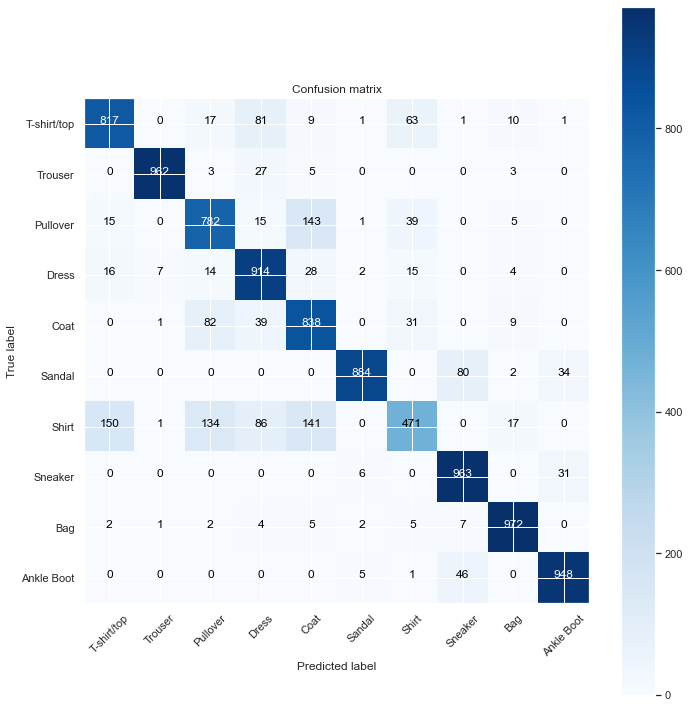

In [74]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm,classes)